In [40]:
import matplotlib.pyplot as plt
import numpy as np

# ChRmine
irr_1p = np.array([0.01, 0.05, 0.22, 0.64, 1.42])  # mW/mm2
I_1p = np.array(
    [  # nA
        0.2886803623803128,
        2.4244584619798237,
        4.114091789682305,
        4.637010169751716,
        4.663515508375585,
    ]
)
power_2p = np.array(
    [
        1.758409161619387,
        7.759939823443684,
        18.27217199407987,
        32.8363883380391,
        50.840977407076835,
    ]
)
I_2p = np.array(
    [
        0.0677292632963725,
        0.43824699419092045,
        1.1215139595623866,
        1.8266932442474064,
        2.3784859137876424,
    ]
)
irr_2p = np.array(power_2p) / (np.pi * 0.01**2)

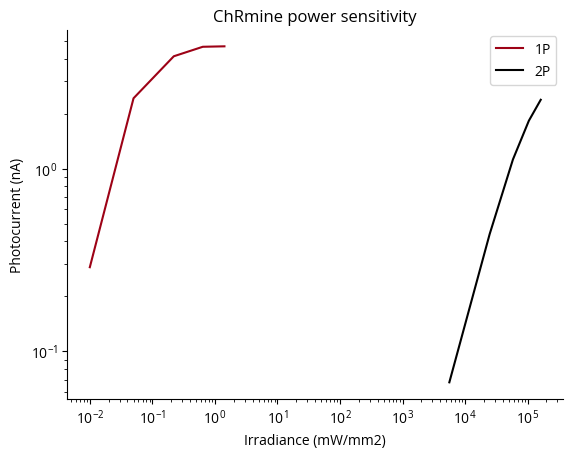

In [60]:
fig, ax = plt.subplots()
ax.loglog((irr_1p), (I_1p), c="xkcd:carmine", label="1P")
ax.plot((irr_2p), (I_2p), c="k", label="2P")
ax.set(
    xlabel="Irradiance (mW/mm2)",
    ylabel="Photocurrent (nA)",
    title="ChRmine power sensitivity",
)
ax.legend()

f_irr=identity, f_I=identity, r2_1p=-0.460, r2_2p=0.971
f_irr=identity, f_I=log, r2_1p=-0.596, r2_2p=0.556
f_irr=identity, f_I=sqrt, r2_1p=-1.990, r2_2p=0.494
f_irr=identity, f_I=square, r2_1p=0.448, r2_2p=0.887
f_irr=log, f_I=identity, r2_1p=-3.182, r2_2p=0.274
f_irr=log, f_I=log, r2_1p=-1.776, r2_2p=-0.246
f_irr=log, f_I=sqrt, r2_1p=-3.516, r2_2p=0.411
f_irr=log, f_I=square, r2_1p=nan, r2_2p=0.024
f_irr=sqrt, f_I=identity, r2_1p=0.507, r2_2p=0.901
f_irr=sqrt, f_I=log, r2_1p=0.171, r2_2p=0.204
f_irr=sqrt, f_I=sqrt, r2_1p=-0.877, r2_2p=0.968
f_irr=sqrt, f_I=square, r2_1p=0.811, r2_2p=0.535
f_irr=square, f_I=identity, r2_1p=-1.470, r2_2p=0.635
f_irr=square, f_I=log, r2_1p=-0.718, r2_2p=0.626
f_irr=square, f_I=sqrt, r2_1p=-2.200, r2_2p=-0.164
f_irr=square, f_I=square, r2_1p=-0.555, r2_2p=0.966
best_f_irr: sqrt
best_f_I: identity
best mean resid: inf
best mean r2 0.703853307246795


/tmp/ipykernel_283243/2063648084.py:47: RuntimeWarning: invalid value encountered in sqrt
  I_hat_1p = f_I_inv(m1p * irr_1p_transformed)


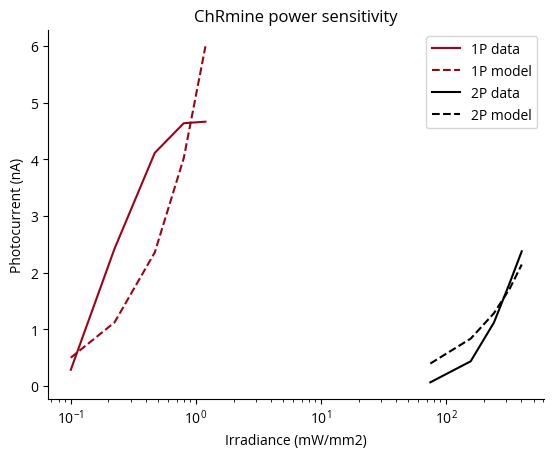

In [57]:
from scipy.optimize import curve_fit


# can we get a good linear fit
def identity(x):
    return np.multiply(x, 1)


def square(x):
    return np.power(x, 2)


fns_and_invs = [
    (identity, identity),
    (np.log, np.exp),
    (np.sqrt, square),
    (square, np.sqrt),
]

from itertools import product


def f_lin(x, m):
    return x * m


def opt(irr, I):
    opt = curve_fit(f_lin, irr, I, [1], full_output=True)
    m = opt[0][0]
    percent_resid2 = np.sum(opt[2]["fvec"] ** 2) / np.sum(I_1p_transformed**2)
    return m, percent_resid2


best_res = np.inf
best_r2 = -np.inf
for (f_irr, f_irr_inv), (f_I, f_I_inv) in product(fns_and_invs, fns_and_invs):
    irr_1p_transformed = f_irr(irr_1p)
    irr_2p_transformed = f_irr(irr_2p)
    I_1p_transformed = f_I(I_1p)
    I_2p_transformed = f_I(I_2p)

    m1p, percent_resid2_1p = opt(irr_1p_transformed, I_1p_transformed)
    m2p, percent_resid2_2p = opt(irr_2p_transformed, I_2p_transformed)
    # print(percent_resid2_1p, percent_resid2_2p)
    tot_res = np.mean([percent_resid2_1p, percent_resid2_2p])

    I_hat_1p = f_I_inv(m1p * irr_1p_transformed)
    r2_1p = 1 - np.sum((I_hat_1p - I_1p) ** 2) / np.sum((I_1p - np.mean(I_1p)) ** 2)

    I_hat_2p = f_I_inv(m2p * irr_2p_transformed)
    r2_2p = 1 - np.sum((I_hat_2p - I_2p) ** 2) / np.sum((I_2p - np.mean(I_2p)) ** 2)

    print(
        f"f_irr={f_irr.__name__}, f_I={f_I.__name__}, r2_1p={r2_1p:.3f}, r2_2p={r2_2p:.3f}"
    )
    mean_r2 = np.mean([r2_1p, r2_2p])

    # if tot_res < best_res:
    if mean_r2 > best_r2:
        # best_res = tot_res
        best_r2 = mean_r2
        best_f_irr = f_irr
        best_f_I = f_I
        best_I_hat_1p = I_hat_1p
        best_I_hat_2p = I_hat_2p
print(f"best_f_irr: {best_f_irr.__name__}")
print(f"best_f_I: {best_f_I.__name__}")
print(f"best mean resid: {best_res}")
print("best mean r2", best_r2)

fig, ax = plt.subplots()
ax.semilogx(best_f_irr(irr_1p), best_f_I(I_1p), c="xkcd:carmine", label="1P data")
ax.plot(
    best_f_irr(irr_1p),
    best_I_hat_1p,
    c="xkcd:carmine",
    linestyle="--",
    label="1P model",
)
ax.plot(best_f_irr(irr_2p), best_f_I(I_2p), c="k", label="2P data")
ax.plot(best_f_irr(irr_2p), best_I_hat_2p, c="k", linestyle="--", label="2P model")
ax.set(
    xlabel="Irradiance (mW/mm2)",
    ylabel="Photocurrent (nA)",
    title="ChRmine power sensitivity",
)
ax.legend()